In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
    

In [2]:
#LSTM Implementation for Sentiment Analysis 

#Importing Libraries
from __future__ import print_function
import numpy as np # linear algebra
import pandas as pd # data processing

from sklearn.feature_extraction.text import CountVectorizer 
from keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SpatialDropout1D, Flatten, Embedding, LSTM
from tensorflow.keras import backend
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re

In [3]:
#reading file 
data = pd.read_csv('twitter_sentiment_data.csv')
data

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153
...,...,...,...
43938,1,"Dear @realDonaldTrump,\nYeah right. Human Medi...",791307031919550464
43939,1,What will your respective parties do to preven...,791316857403936768
43940,2,RT @MikkiL: UN Poll Shows Climate Change Is th...,791357509101621249
43941,0,RT @taehbeingextra: i still can$q$t believe th...,791390042136641537


In [4]:
#keeping only necessary columns
data = data[['message','sentiment']]
data.head(5)

,message,sentiment
0,@tiniebeany climate change is an interesting h...,-1
1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,1
2,Fabulous! Leonardo #DiCaprio's film on #climat...,1
3,RT @Mick_Fanning: Just watched this amazing do...,1
4,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",2


In [5]:
print(data.message[1])

RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦


In [6]:
print(data.message[4])

RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the poÃ¢â‚¬Â¦


In [7]:
#Checking the number of unique values in sentiment column as my objective will be to work only with strictly positive or strictly negative tweets
for cat in ['sentiment']:
    print("Levels for category '{0}': {1}".format(cat, data[cat].unique()))

Levels for category 'sentiment': [-1  1  2  0]


In [8]:
data.sentiment.value_counts()

 1    22962
 2     9276
 0     7715
-1     3990
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment'>

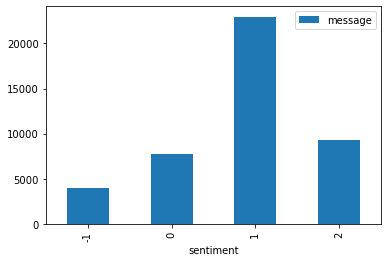

In [9]:
data.groupby('sentiment').count().plot(kind='bar')

In [10]:
#we see uneven sample distributions for negative and positive sentiment valued tweets. Thus we try to somewhat even distribution by including only positive or only negative tweets Usually, in such a case accuracy may not provide a fair view due to the bias in the data, thus we may use other metrics such as F1 score for measuring model stability and robustness
values = [1,0]
data = data[data.sentiment.isin(values) == False]

In [11]:
data.sentiment.value_counts()

 2    9276
-1    3990
Name: sentiment, dtype: int64

In [12]:
data

,message,sentiment
0,@tiniebeany climate change is an interesting h...,-1
4,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",2
6,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",2
7,RT @CCIRiviera: Presidential Candidate #Donald...,2
14,RT @WorldResources: Reflections on Leonardo Di...,2
...,...,...
43931,Global warming provides a great excuse for glo...,-1
43932,RT @nereusprogram: Climate change could cause ...,2
43935,RT @PrisonPlanet: Americans More Scared of Clo...,-1
43937,RT @cnni: Leonardo DiCaprio: $q$Not one questi...,2


In [13]:
#Removing unnecessary characters
data['message'] = data['message'].apply(lambda x: x.lower())
data['message'] = data['message'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
print(data[ data['sentiment'] == '2'].size)
print(data[ data['sentiment'] == '-1'].size)

0
0


In [14]:
#Preprocessing for certain characters occurring frequently in tweets
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

In [15]:
from keras_preprocessing.sequence import pad_sequences

In [16]:
#Tokenizing and padding the sequences
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['message'].values)
X = tokenizer.texts_to_sequences(data['message'].values)
X = pad_sequences(X)

In [17]:
#Building Testing Training and Validating model

#Specifying dimensions of embeddings Adding layers by calling sequential() Mentioning dropout dimensions Adding lstm layer Calling activation function softmax In the end compiling loss function(categrical cross entropy)

#Here softmax is used because of its ability of working well with categorical cross entropy

embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 128)           256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 30, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 2)                 394       
                                                                 
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
#Train Test Split

Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8888, 30) (8888, 2)
(4378, 30) (4378, 2)


In [19]:
#Sampling a batch for traning and fitting model 12 epochs are run 1 epoch is completed after the number of iterations, which is derived by the Total Samples divided by a batch size, is obtained.
batch_size = 40
model.fit(X_train, Y_train, epochs = 12, batch_size=batch_size, verbose = 2)

Epoch 1/12
223/223 - 12s - loss: 0.3184 - accuracy: 0.8583 - 12s/epoch - 53ms/step
Epoch 2/12
223/223 - 10s - loss: 0.1545 - accuracy: 0.9401 - 10s/epoch - 44ms/step
Epoch 3/12
223/223 - 10s - loss: 0.1199 - accuracy: 0.9560 - 10s/epoch - 43ms/step
Epoch 4/12
223/223 - 10s - loss: 0.0983 - accuracy: 0.9659 - 10s/epoch - 44ms/step
Epoch 5/12
223/223 - 10s - loss: 0.0817 - accuracy: 0.9707 - 10s/epoch - 44ms/step
Epoch 6/12
223/223 - 10s - loss: 0.0654 - accuracy: 0.9763 - 10s/epoch - 44ms/step
Epoch 7/12
223/223 - 10s - loss: 0.0538 - accuracy: 0.9817 - 10s/epoch - 44ms/step
Epoch 8/12
223/223 - 10s - loss: 0.0458 - accuracy: 0.9831 - 10s/epoch - 44ms/step
Epoch 9/12
223/223 - 10s - loss: 0.0441 - accuracy: 0.9850 - 10s/epoch - 44ms/step
Epoch 10/12
223/223 - 10s - loss: 0.0366 - accuracy: 0.9873 - 10s/epoch - 44ms/step
Epoch 11/12
223/223 - 10s - loss: 0.0339 - accuracy: 0.9871 - 10s/epoch - 43ms/step
Epoch 12/12
223/223 - 10s - loss: 0.0319 - accuracy: 0.9887 - 10s/epoch - 44ms/step


In [20]:
#Validating on test
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc*100))

72/72 - 1s - loss: 0.3671 - accuracy: 0.9239 - 795ms/epoch - 11ms/step
score: 0.37
acc: 92.39


In [21]:
#We can observe the dataset performs better on training because it was optimized for training and not test. This assures stability inn performance of the model. It means that during test a similar distribution was used as used for training, implying the cosistency with the sampling
 pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1
print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")


1/1 - 0s - 166ms/epoch - 166ms/step
1/1 - 0s - 4ms/epoch - 4ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 3ms/epoch - 3ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 8ms/epoch - 8ms/step
1/1 - 0s - 7ms/epoch - 7ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 6ms/epoch - 6ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 3ms/epoch - 3ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 6ms/epoch - 6ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 5ms/epoch - 5ms